# Nhận dạng thực thể có tên sử dụng sklearn-crfsuite

Trong notebook này, chúng ta huấn luyện mô hình CRF cơ bản cho nhận dạng thực thể có tên trên dữ liệu CoNLL2002 và kiểm tra trọng số của mô hình để xem mô hình học được những gì.

Chúng ta cần các thư viện Python NLTK> 3.x và sklearn-crfsuite, sử dụng Python 3.




In [1]:
!pip install sklearn_crfsuite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 7.8 MB/s eta 0:00:00


In [2]:
import nltk
import sklearn_crfsuite
import numpy as np
nltk.download('conll2002')

[nltk_data] Downloading package conll2002 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2002.zip.


True

# 1. Dữ liệu huấn luyện (Training data)

Bộ dữ liệu CoNLL 2002 chứa danh sách các câu tiếng Tây Ban Nha, với các thực thể có tên được chú giải. Bộ dữ liệu này sử dụng mã hóa IOB2. Dữ liệu CoNLL 2002 cũng cung cấp các thẻ POS.

In [3]:
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))
train_sents[0]

[('Melbourne', 'NP', 'B-LOC'),
 ('(', 'Fpa', 'O'),
 ('Australia', 'NP', 'B-LOC'),
 (')', 'Fpt', 'O'),
 (',', 'Fc', 'O'),
 ('25', 'Z', 'O'),
 ('may', 'NC', 'O'),
 ('(', 'Fpa', 'O'),
 ('EFE', 'NC', 'B-ORG'),
 (')', 'Fpt', 'O'),
 ('.', 'Fp', 'O')]

# 2. Trích xuất đặc trưng

Thẻ POS có thể được xem như là các đặc trưng được trích xuất trước. Hãy trích xuất các đặc trưng khác (word parts, thẻ từ loại đã rút gọn - simplified POS tags, lower/title/upper flags, đặc trưng của các từ lân cận - features of nearby words) và chuyển đổi chúng sang định dạng sklear-crfsuite - mỗi một câu phải được chuyển đổi thành một danh sách của từ điển. Đây là một đường cơ sở rất đơn giản; bạn chắc chắn có thể làm tốt hơn.

In [4]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

Các đặc trưng được trích xuất từ một token duy nhất có dạng như sau:

In [5]:
X_train[0][1]

{'bias': 1.0,
 'word.lower()': '(',
 'word[-3:]': '(',
 'word.isupper()': False,
 'word.istitle()': False,
 'word.isdigit()': False,
 'postag': 'Fpa',
 'postag[:2]': 'Fp',
 '-1:word.lower()': 'melbourne',
 '-1:word.istitle()': True,
 '-1:word.isupper()': False,
 '-1:postag': 'NP',
 '-1:postag[:2]': 'NP',
 '+1:word.lower()': 'australia',
 '+1:word.istitle()': True,
 '+1:word.isupper()': False,
 '+1:postag': 'NP',
 '+1:postag[:2]': 'NP'}

# 3. Huấn luyện mô hình CRF

Khi chúng ta có các đặc trưng ở định dạng phù hợp chúng ta có thể huấn luyện mô hình CRF chuỗi tuyến tính (Trường điều kiện ngẫu nhiên - CRFs) bằng cách sử dụng sklearn_crfsuite.CRF:

In [6]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=50,
    all_possible_transitions=False,
)
crf.fit(X_train, y_train);

In [7]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-LOC', 'B-ORG', 'B-PER', 'I-PER', 'B-MISC', 'I-ORG', 'I-LOC', 'I-MISC']

In [8]:
y_pred = crf.predict(X_test)

In [9]:
from sklearn.metrics import classification_report

In [10]:
gold=[]
for _ in y_test:
    gold+=_
pred=[]
for _ in y_pred:
    pred+=_
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(classification_report(
    gold, pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

       B-LOC      0.796     0.780     0.788      1084
       I-LOC      0.687     0.622     0.653       325
      B-MISC      0.710     0.569     0.632       339
      I-MISC      0.685     0.594     0.637       557
       B-ORG      0.799     0.843     0.820      1400
       I-ORG      0.828     0.805     0.816      1104
       B-PER      0.885     0.868     0.876       735
       I-PER      0.915     0.929     0.922       634

   micro avg      0.808     0.788     0.798      6178
   macro avg      0.788     0.751     0.768      6178
weighted avg      0.805     0.788     0.795      6178



# 4. Kiểm tra trọng số mô hình

Các mô hình CRF của CRFsuite sử dụng hai loại đặc trưng: đặc trưng trạng thái và đặc trưng chuyển tiếp. Hãy kiểm tra trọng số của chúng:



In [11]:
import pandas as pd

In [24]:
crf.transition_features_[ ('B-ORG', 'I-PER')]

-2.122401

In [32]:
def gettransition_features(crf,targets=None):
    d=crf.transition_features_
    if targets is None:
        row_names = list(set(row_name for row_name,_ in d))
        column_names = list(set(column_name for _,column_name in d))
    else:
        row_names=targets
        column_names=targets
    df=pd.DataFrame(columns=column_names,index=row_names)
    for row_name in row_names:
        for column_name in column_names:
            df[column_name][row_name]=d[(row_name,column_name)]
    return df
def getstate_features(crf,top=30,targets=None):
    d=crf.state_features_
    row_names = list(set(row_name for row_name,_ in d))
    column_names = list(set(column_name for _,column_name in d))
    df=pd.DataFrame(columns=column_names,index=row_names)
    for (row_name,column_name), score in d.items():
        df.at[row_name,column_name]=score
    if targets is None:
        targets=column_names
    dfres=pd.DataFrame(columns=targets,index=[i for i in range(top)])
    for col in targets:
        df1=df[col].dropna()
        for i,(x,y) in enumerate(df1.sort_values(ascending=False)[:top].items()):
            dfres[col][i]=str(x)+' '+str(y)
    return dfres


In [28]:
getstate_features(crf)

,B-ORG,B-PER,B-LOC,I-LOC,I-ORG,I-PER,O,B-MISC,I-MISC
0,word.isupper() 3.040547,word.istitle() 1.757319,word.istitle() 2.396801,-1:word.lower():de 0.881613,-1:word.lower():de 1.158985,-1:word.istitle() 1.544951,BOS 4.931176,word.isupper() 2.016886,-1:word.istitle() 0.863544
1,word.lower():efe 2.952151,+1:postag:VMI 0.745051,-1:word.lower():en 2.146674,-1:word.istitle() 0.780042,-1:word.istitle() 0.992838,word.istitle() 0.975902,postag[:2]:Fp 3.754403,word.istitle() 0.603388,-1:word.lower():de 0.615973
2,word[-3:]:EFE 1.850966,-1:postag:VMI 0.615268,word[-3:]:rid 0.978281,word[-3:]:de 0.718214,-1:postag[:2]:SP 0.636564,-1:word.lower():josé 0.694515,bias 3.538947,postag:Fe 0.5456,+1:postag[:2]:Fe 0.590637
3,word.lower():gobierno 1.278428,postag[:2]:NP 0.600945,word.lower():madrid 0.977224,word.lower():de 0.710899,-1:postag:SP 0.636564,postag:NC 0.676606,"word.lower():, 2.32761","word[-3:]:"" 0.5456",+1:postag:Fe 0.590637
4,word[-3:]:rno 1.033159,postag:NP 0.600945,word[-3:]:ona 0.68525,-1:word.lower():san 0.553371,-1:word.lower():real 0.569994,postag[:2]:NC 0.676606,postag:Fc 2.32761,postag[:2]:Fe 0.5456,"+1:word.lower():"" 0.590637"
5,word.istitle() 1.005305,word[-3:]:osé 0.555085,word.lower():españa 0.674248,word.istitle() 0.460237,word.istitle() 0.547423,-1:word.lower():juan 0.513856,postag[:2]:Fc 2.32761,"word.lower():"" 0.5456",-1:postag:NC 0.413782
6,-1:word.lower():del 0.863561,-1:word.lower():a 0.548284,word[-3:]:aña 0.61937,+1:word.istitle() 0.459539,+1:postag:Fe 0.459033,-1:postag:VMI 0.511631,"word[-3:]:, 2.32761",postag[:2]:NC 0.490598,-1:postag[:2]:NC 0.413782
7,postag:NC 0.716049,word.lower():josé 0.537843,+1:postag[:2]:Fp 0.609551,-1:postag[:2]:SP 0.432397,+1:postag[:2]:Fe 0.459033,-1:postag[:2]:VM 0.473467,postag[:2]:CC 2.140987,postag:NC 0.490598,-1:word.lower():liga 0.352
8,postag[:2]:NC 0.716049,postag[:2]:NC 0.526792,BOS 0.562157,-1:postag:SP 0.432397,"+1:word.lower():"" 0.459033",+1:word.istitle() 0.443075,postag:CC 2.140987,postag[:2]:Z 0.453928,postag:NC 0.299905
9,word[-3:]:PP 0.694327,postag:NC 0.526792,word.lower():parís 0.522645,postag[:2]:SP 0.384002,word[-3:]:rid 0.456152,-1:word.lower():maría 0.442334,EOS 1.927981,postag:Z 0.453928,postag[:2]:NC 0.299905


In [14]:
gettransition_features(crf)

,B-ORG,B-PER,B-LOC,I-LOC,I-ORG,I-PER,O,B-MISC,I-MISC
B-ORG,-1.668179,-0.295286,0.635639,NaN,9.090699,NaN,-0.125475,-2.26201,NaN
B-PER,-0.982599,-2.803074,-0.778107,NaN,NaN,11.194026,-0.103723,NaN,NaN
B-LOC,NaN,-0.226743,0.604672,9.552027,NaN,NaN,-0.30079,NaN,NaN
I-LOC,NaN,NaN,-3.074556,8.37189,NaN,NaN,-0.69395,NaN,NaN
I-ORG,-1.751767,0.201736,-2.553301,NaN,9.526659,NaN,-0.365947,-2.383614,NaN
I-PER,NaN,-2.201352,-0.609085,NaN,NaN,7.771799,-1.283047,NaN,NaN
O,5.850349,4.031904,3.675905,NaN,NaN,NaN,5.059954,4.66006,NaN
B-MISC,-0.125216,-2.104527,-2.068572,NaN,NaN,NaN,-1.130722,NaN,8.658278
I-MISC,-2.275223,-1.053123,-3.301188,NaN,NaN,NaN,-1.179783,-1.492927,9.305806


In [15]:
import matplotlib.pyplot as plt
def showmatrix(df):
    matrix=df.values.tolist()
    plt.figure(figsize=(10,10))
    plt.imshow(df.values.tolist(), cmap='Blues')
    plt.xticks(range(len(df.columns)), df.columns)
    plt.yticks(range(len(df.index)), df.index)
    for i in range(len(matrix[0])):
        for j in range(len(matrix)):
            c = matrix[j][i]
            if not np.isnan(c):
                plt.text(i, j, f'{c:.2f}', va='center', ha='center')
    plt.colorbar()
    plt.show()


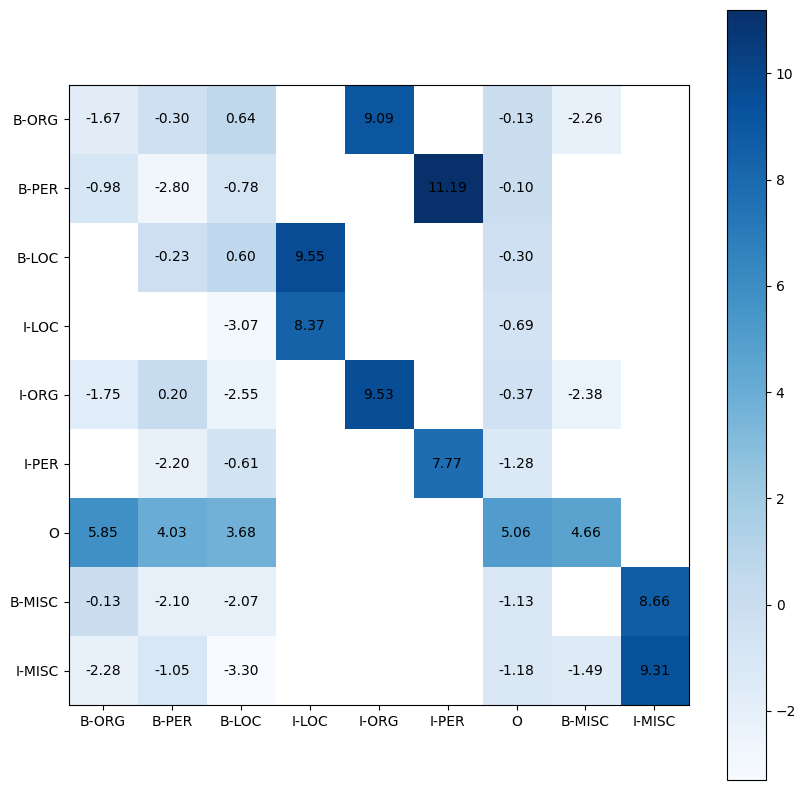

In [17]:
showmatrix(gettransition_features(crf))


Các đặc trưng chuyển tiếp có ý nghĩa: ít nhất mô hình đã học rằng I-ENTITY phải theo sau B-ENTITY. Nó cũng học được rằng một số chuyển tiếp khó xảy ra, ví dụ: ngay sau tên tổ chức thường không phải là một vị trí (I-ORG -> B-LOC có trọng số âm lớn).

Các đặc trưng không sử dụng từ điển địa lý, vì vậy mô hình phải nhớ một số tên địa lý từ dữ liệu huấn luyện, ví dụ: España là một địa điểm.

Nếu chúng ta regularize CRF hơn, chúng ta có thể kỳ vọng rằng các đặc trưng duy nhất mang tính tổng quát sẽ vẫn còn, và thẻ ghi nhớ sẽ mất đi. Với hệ số chính quy L1 (tham số c1) của hầu hết các đặc trưng sẽ được chuyển về không. Hãy kiểm tra xem việc regularization có ảnh hưởng gì đến trọng số CRF:


In [18]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=20,
    c2=0.1,
    max_iterations=50,
    all_possible_transitions=False,
)
crf.fit(X_train, y_train);

In [26]:
getstate_features(crf)

,B-ORG,B-PER,B-LOC,I-LOC,I-ORG,I-PER,O,B-MISC,I-MISC
0,word.isupper() 3.040547,word.istitle() 1.757319,word.istitle() 2.396801,-1:word.lower():de 0.881613,-1:word.lower():de 1.158985,-1:word.istitle() 1.544951,BOS 4.931176,word.isupper() 2.016886,-1:word.istitle() 0.863544
1,word.lower():efe 2.952151,+1:postag:VMI 0.745051,-1:word.lower():en 2.146674,-1:word.istitle() 0.780042,-1:word.istitle() 0.992838,word.istitle() 0.975902,postag[:2]:Fp 3.754403,word.istitle() 0.603388,-1:word.lower():de 0.615973
2,word[-3:]:EFE 1.850966,-1:postag:VMI 0.615268,word[-3:]:rid 0.978281,word[-3:]:de 0.718214,-1:postag[:2]:SP 0.636564,-1:word.lower():josé 0.694515,bias 3.538947,postag:Fe 0.5456,+1:postag[:2]:Fe 0.590637
3,word.lower():gobierno 1.278428,postag[:2]:NP 0.600945,word.lower():madrid 0.977224,word.lower():de 0.710899,-1:postag:SP 0.636564,postag:NC 0.676606,"word.lower():, 2.32761","word[-3:]:"" 0.5456",+1:postag:Fe 0.590637
4,word[-3:]:rno 1.033159,postag:NP 0.600945,word[-3:]:ona 0.68525,-1:word.lower():san 0.553371,-1:word.lower():real 0.569994,postag[:2]:NC 0.676606,postag:Fc 2.32761,postag[:2]:Fe 0.5456,"+1:word.lower():"" 0.590637"
5,word.istitle() 1.005305,word[-3:]:osé 0.555085,word.lower():españa 0.674248,word.istitle() 0.460237,word.istitle() 0.547423,-1:word.lower():juan 0.513856,postag[:2]:Fc 2.32761,"word.lower():"" 0.5456",-1:postag:NC 0.413782
6,-1:word.lower():del 0.863561,-1:word.lower():a 0.548284,word[-3:]:aña 0.61937,+1:word.istitle() 0.459539,+1:postag:Fe 0.459033,-1:postag:VMI 0.511631,"word[-3:]:, 2.32761",postag[:2]:NC 0.490598,-1:postag[:2]:NC 0.413782
7,postag:NC 0.716049,word.lower():josé 0.537843,+1:postag[:2]:Fp 0.609551,-1:postag[:2]:SP 0.432397,+1:postag[:2]:Fe 0.459033,-1:postag[:2]:VM 0.473467,postag[:2]:CC 2.140987,postag:NC 0.490598,-1:word.lower():liga 0.352
8,postag[:2]:NC 0.716049,postag[:2]:NC 0.526792,BOS 0.562157,-1:postag:SP 0.432397,"+1:word.lower():"" 0.459033",+1:word.istitle() 0.443075,postag:CC 2.140987,postag[:2]:Z 0.453928,postag:NC 0.299905
9,word[-3:]:PP 0.694327,postag:NC 0.526792,word.lower():parís 0.522645,postag[:2]:SP 0.384002,word[-3:]:rid 0.456152,-1:word.lower():maría 0.442334,EOS 1.927981,postag:Z 0.453928,postag[:2]:NC 0.299905


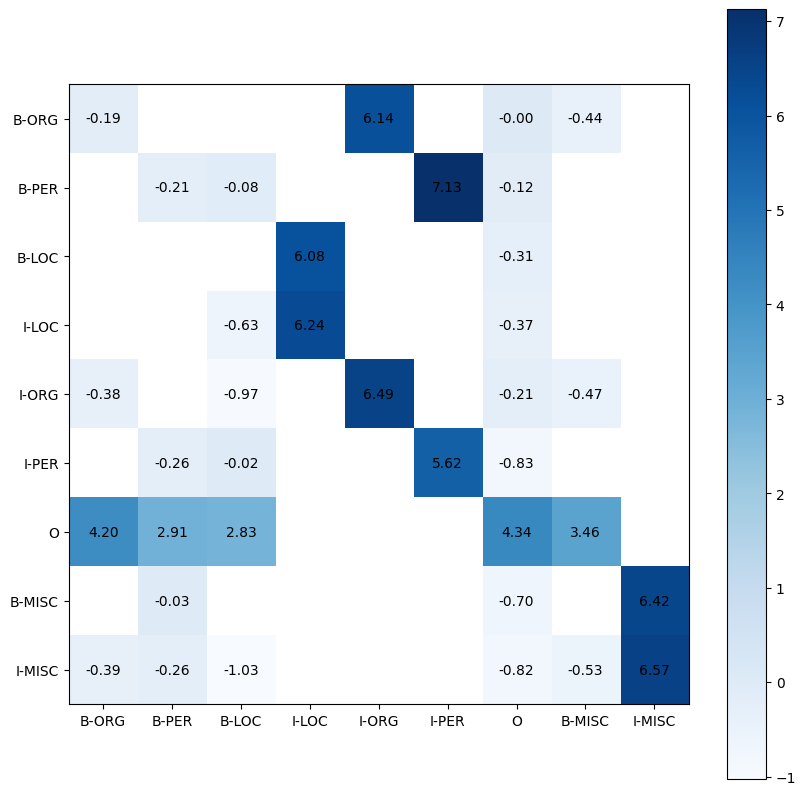

In [20]:
showmatrix(gettransition_features(crf))

Như chúng ta có thể thấy, các thẻ được ghi nhớ hầu hết đã biến mất và mô hình hiện dựa vào khuôn dạng từ (word shapes) và nhãn từ loại (POS tags). Chỉ còn lại một số đặc trưng khác không. Trong ví dụ này, sự thay đổi có thể khiến chất lượng kém hơn, nhưng đó là một vấn đề riêng.

Hãy tập trung vào trọng số chuyển tiếp. Chúng ta có thể cho rằng các chuyển tiếp O -> I-ENTIRY có trọng số âm lớn vì chúng là không thể. Nhưng những chuyển tiếp này có trọng số bằng không, không có trọng số âm, cả trong mô hình được chính quy hóa nhiều và trong mô hình ban đầu. Có gì đó đang xảy ra ở đây.

Lý do chúng bằng 0 là crfsuite đã không nhìn thấy những chuyển đổi này trong dữ liệu huấn luyện và để tiết kiệm thời gian tính toán nên đã cho rằng không cần phải học trọng số đối với chúng. Đây là mặc định, nhưng có thể tắt nó bằng cách sử dụng sklearn_crfsuite.CRF tùy chọn all_possible_transitions. Hãy kiểm tra xem nó ảnh hưởng như thế nào đến kết quả:

In [21]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=20,
    all_possible_transitions=True,
)
crf.fit(X_train, y_train);

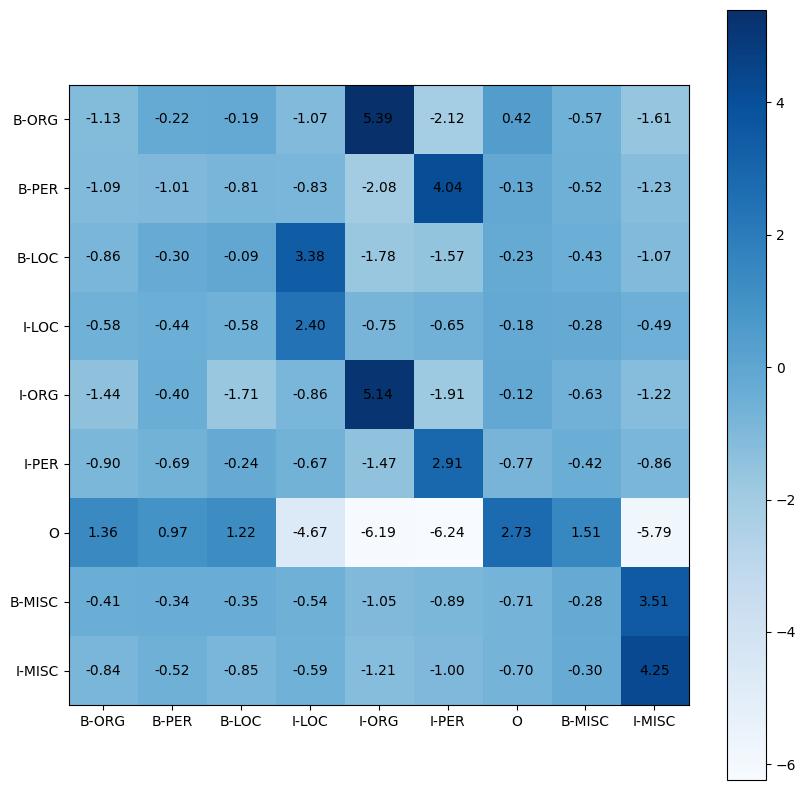

In [33]:
showmatrix(gettransition_features(crf))

Với all_possible_transitions = True CRF đã học được các trọng số âm lớn cho các chuyển đổi không thể như O -> I-ORG.

# 5. Tùy chỉnh
Bảng trên lớn và khó quan sát, ta sẽ sử dụng một số tùy chọn để chỉ xem xét một phần của các đặc trưng. Chúng ta có thể chỉ kiểm tra một tập hợp con các nhãn:

In [29]:
getstate_features(crf,top=10, targets=['O', 'B-ORG', 'I-ORG'])

,O,B-ORG,I-ORG
0,BOS 4.931176,word.isupper() 3.040547,-1:word.lower():de 1.158985
1,postag[:2]:Fp 3.754403,word.lower():efe 2.952151,-1:word.istitle() 0.992838
2,bias 3.538947,word[-3:]:EFE 1.850966,-1:postag[:2]:SP 0.636564
3,"word.lower():, 2.32761",word.lower():gobierno 1.278428,-1:postag:SP 0.636564
4,postag:Fc 2.32761,word[-3:]:rno 1.033159,-1:word.lower():real 0.569994
5,postag[:2]:Fc 2.32761,word.istitle() 1.005305,word.istitle() 0.547423
6,"word[-3:]:, 2.32761",-1:word.lower():del 0.863561,+1:postag:Fe 0.459033
7,postag[:2]:CC 2.140987,postag:NC 0.716049,+1:postag[:2]:Fe 0.459033
8,postag:CC 2.140987,postag[:2]:NC 0.716049,"+1:word.lower():"" 0.459033"
9,EOS 1.927981,word[-3:]:PP 0.694327,word[-3:]:rid 0.456152


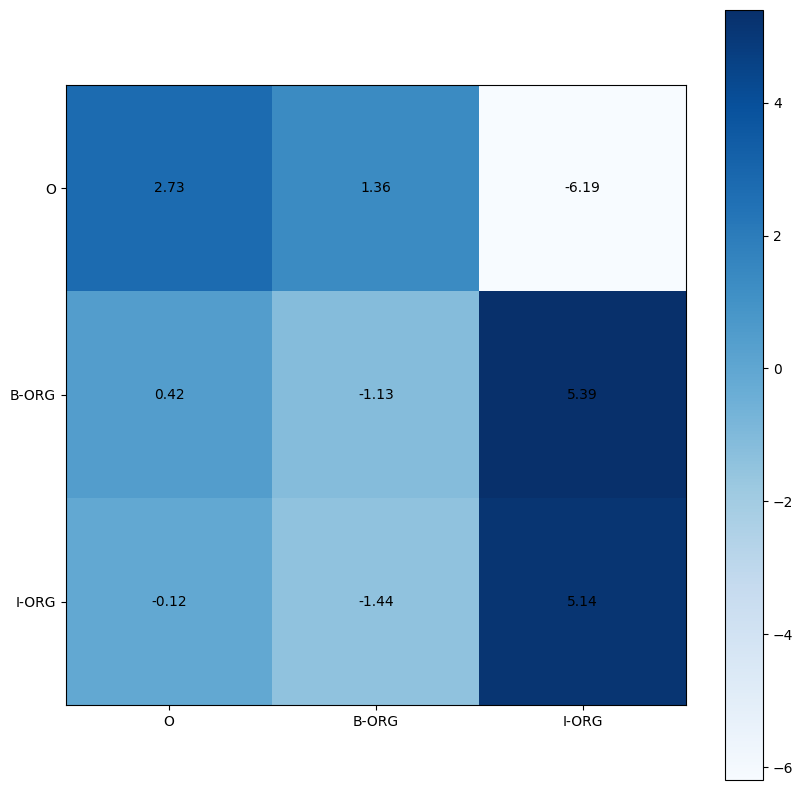

In [34]:
showmatrix(gettransition_features(crf, targets=['O', 'B-ORG', 'I-ORG']))